# Определение возраста покупателей

**Дано**: 
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
* Контролировать добросовестность кассиров при продаже алкоголя

**Задача:** Построить модель, которая по фотографии определит приблизительный возраст человека. Дан набор фотографий людей с указанием возраста

## Исследовательский анализ данных

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

In [3]:
csv = '/datasets/faces/labels.csv'
img = '/datasets/faces/final_files/'

In [4]:
data = pd.read_csv(csv)
pd.set_option('display.max_rows', None)#параметр для выводы всего датафрейма
data.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [10]:
def so(data):
    print(f'Размер датасета - {data.shape}')
    print()
    print('Информация о данных:')
    print(data.info())
    print()
    print(f'Количество пропусков в датасете: {data.isna().sum().sum()}')
    print(f'Указание на пропуски в датасете: {data.isna().sum()}')
    print(f'Дубликаты в датасете: {data.duplicated().sum()}')
    print(data.describe())

In [11]:
so(data)

Размер датасета - (7591, 2)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

Количество пропусков в датасете: 0
Указание на пропуски в датасете: file_name    0
real_age     0
dtype: int64
Дубликаты в датасете: 0
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


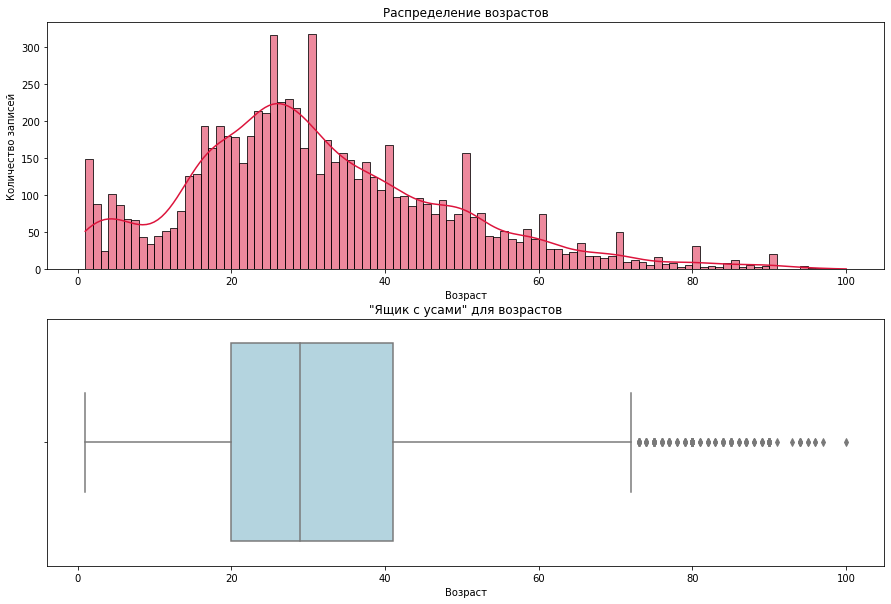

In [13]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
sns.histplot(data['real_age'], bins=99, kde=True, color = 'crimson')
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество записей')

plt.subplot(2, 1, 2)
sns.boxplot(data['real_age'],color = 'lightblue')
plt.title('"Ящик с усами" для возрастов')
plt.xlabel('Возраст')

plt.show()

* Наблюдаем, что больше всего людей в возрасте от 20 до 40 лет;
* Меньше всего людей в возрасте до 9 и старше 60;
* Распределение близкое к нормальному.

In [26]:
datagen = ImageDataGenerator(rescale=1/255.)
train_datagen_flow = datagen.flow_from_dataframe(
    directory=img,
    dataframe=data,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=500,
    class_mode='raw',
    seed=12345)
features, target = next(train_datagen_flow)

Found 7591 validated image filenames.


In [33]:
def foto(age):
    print('Возраст от ', age - 5,' до ', age + 5)
    fig = plt.figure(figsize=(10,10))   
    global s
    s = 0
    for i in range(5):
        fig.add_subplot(1, 5, i+1) 
        
        while target[s] < age-5 or target[s] >= age + 5:
            s += 1
        else:
            plt.imshow(features[s])
            plt.title(target[s])
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            s += 1
    plt.show()

Возраст от  0  до  10


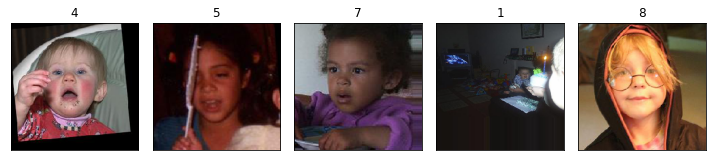

Возраст от  10  до  20


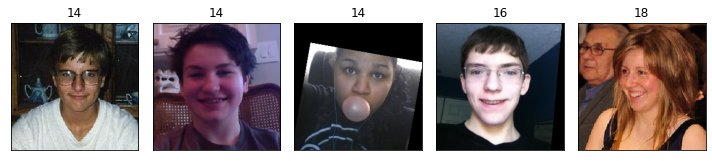

Возраст от  20  до  30


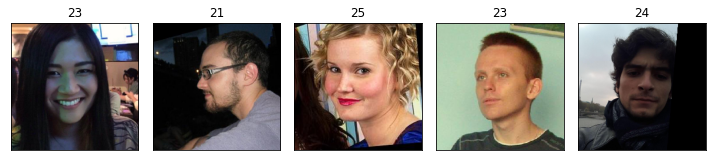

Возраст от  30  до  40


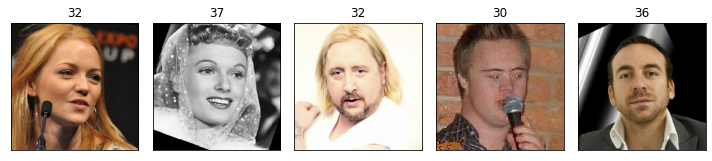

Возраст от  40  до  50


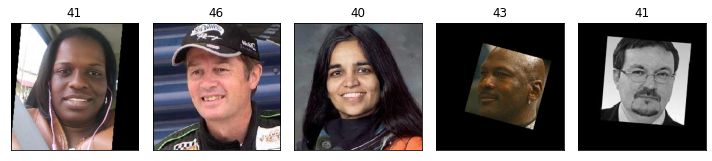

In [41]:
for i in range(5):
    foto(i*10 + 5)

**Вывод:**
* Имеем набор фото с количеством 7951 шт. с данными по возрасту.
* Диапазон возрастов - от 1 года до 100 лет.
* Наблюдаем, что больше всего людей в возрасте от 20 до 40 лет.
* Меньше всего людей в возрасте до 9 и старше 60.
* Распределение бимодальное.
* Встречаются фотографии разных оттенков.
* Не все фото выровнены.

## Обучение модели

```python

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    # создание загрузчика данных
    train_datagen = ImageDataGenerator(validation_split=0.25,
    rescale=1/255,
    vertical_flip=True)
    
    # загрузка данных 
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow



def load_test(path):
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return valid_datagen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    
    model = Sequential() 
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model


def train_model(model, train_data, test_data, batch_size=None,

epochs=10, steps_per_epoch=None,

validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```





```python

2024-02-18 15:14:04.701566: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-02-18 15:14:04.804631: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-02-18 15:14:09.311573: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-02-18 15:14:09.918963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-02-18 15:14:09.919047: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-02-18 15:14:09.919082: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-18 15:14:10.018297: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-02-18 15:14:10.034017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-02-18 15:14:10.204754: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-02-18 15:14:10.238300: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-02-18 15:14:10.238444: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-02-18 15:14:10.242712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-02-18 15:14:11.623781: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-02-18 15:14:11.653196: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2024-02-18 15:14:11.655066: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c05c00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-18 15:14:11.655098: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-02-18 15:14:11.838682: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x46193f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-18 15:14:11.838716: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-02-18 15:14:11.840477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-02-18 15:14:11.840537: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-02-18 15:14:11.840548: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-18 15:14:11.840577: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-02-18 15:14:11.840588: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-02-18 15:14:11.840598: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-02-18 15:14:11.840608: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-02-18 15:14:11.840616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-02-18 15:14:11.844648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-02-18 15:14:11.846156: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-02-18 15:14:13.487396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-02-18 15:14:13.487451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-02-18 15:14:13.487459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-02-18 15:14:13.490816: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-02-18 15:14:13.490868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 40s
   90112/94765736 [..............................] - ETA: 59s
  262144/94765736 [..............................] - ETA: 41s
  802816/94765736 [..............................] - ETA: 19s
 2179072/94765736 [..............................] - ETA: 9s 
 4874240/94765736 [>.............................] - ETA: 4s
 9175040/94765736 [=>............................] - ETA: 2s
13352960/94765736 [===>..........................] - ETA: 2s
17268736/94765736 [====>.........................] - ETA: 1s
21004288/94765736 [=====>........................] - ETA: 1s
25493504/94765736 [=======>......................] - ETA: 1s
29605888/94765736 [========>.....................] - ETA: 1s
33185792/94765736 [=========>....................] - ETA: 1s
37568512/94765736 [==========>...................] - ETA: 1s
41926656/94765736 [============>.................] - ETA: 0s
45465600/94765736 [=============>................] - ETA: 0s
49774592/94765736 [==============>...............] - ETA: 0s
54132736/94765736 [================>.............] - ETA: 0s
57802752/94765736 [=================>............] - ETA: 0s
61800448/94765736 [==================>...........] - ETA: 0s
66076672/94765736 [===================>..........] - ETA: 0s
69861376/94765736 [=====================>........] - ETA: 0s
73596928/94765736 [======================>.......] - ETA: 0s
78053376/94765736 [=======================>......] - ETA: 0s
82067456/94765736 [========================>.....] - ETA: 0s
85868544/94765736 [==========================>...] - ETA: 0s
89997312/94765736 [===========================>..] - ETA: 0s
94404608/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-02-18 15:14:31.983166: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-18 15:14:33.419372: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 64s - loss: 221.9420 - mae: 11.1962 - val_loss: 423.5218 - val_mae: 15.5278
Epoch 2/10
178/178 - 37s - loss: 134.5920 - mae: 8.8320 - val_loss: 364.9715 - val_mae: 14.2171
Epoch 3/10
178/178 - 37s - loss: 106.6733 - mae: 7.9158 - val_loss: 304.7145 - val_mae: 13.3601
Epoch 4/10
178/178 - 37s - loss: 93.8404 - mae: 7.3947 - val_loss: 212.5192 - val_mae: 11.5839
Epoch 5/10
178/178 - 37s - loss: 75.4198 - mae: 6.6356 - val_loss: 131.9572 - val_mae: 8.7163
Epoch 6/10
178/178 - 37s - loss: 59.1243 - mae: 5.9121 - val_loss: 189.1363 - val_mae: 10.1439
Epoch 7/10
178/178 - 37s - loss: 54.5966 - mae: 5.6685 - val_loss: 165.1186 - val_mae: 9.1446
Epoch 8/10
178/178 - 37s - loss: 44.8439 - mae: 5.1466 - val_loss: 156.1670 - val_mae: 9.3012
Epoch 9/10
178/178 - 37s - loss: 37.6516 - mae: 4.7336 - val_loss: 124.5146 - val_mae: 8.2981
Epoch 10/10
178/178 - 37s - loss: 35.1928 - mae: 4.5168 - val_loss: 103.2317 - val_mae: 7.5921
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 103.2317 - mae: 7.5921
Test MAE: 7.5921

```



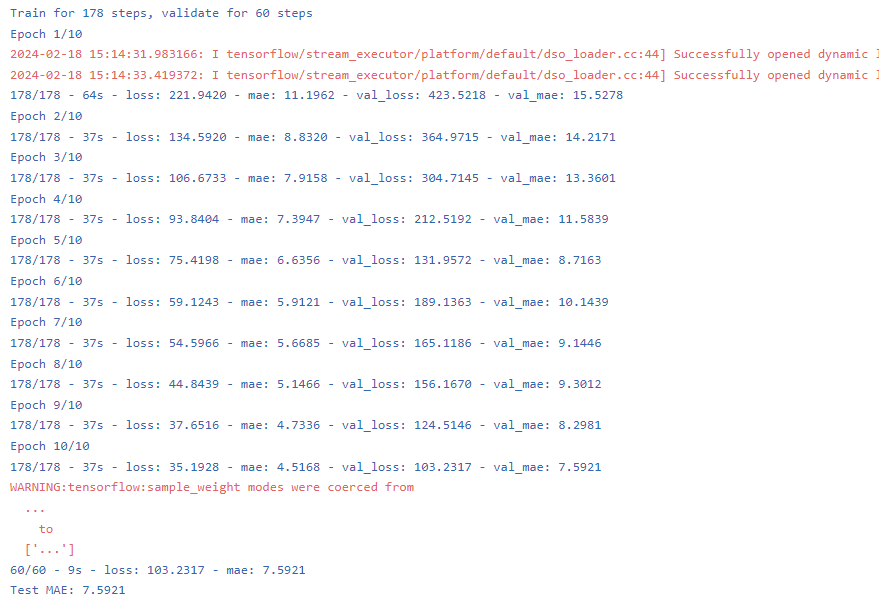

## Анализ обученной модели

* Модель построена на основе ResNet50, и в качестве метрики использовалась MAE;
* Модель показала хороший результат - 7.5921;
* Алгоритмом оптимизации выступала адаптивная оценка момента с lr=lr=0.0005;
* Получена возможность определять возраст покупателей с ошибкой примерно в 7 лет.
* Модель можно внедрять в магазины для решения первой задачи. Это анализ покупок и возможность предлагать товары, которые могут заинтересовать покупателей этой возрастной группы.
* Для решения второй задачи (о продаже алкоголя) качества модели недостаточно.